# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

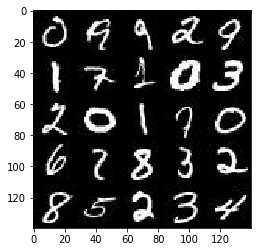

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

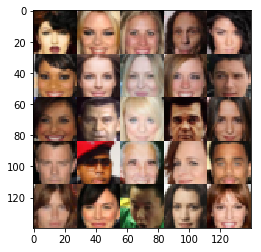

In [3]:
show_n_images = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # images: 28 x 28 x  1or3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(bn2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4 * 4* 224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 4 * 4 * 448)
        x1 = tf.reshape(x1, (-1, 4, 4, 448))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 224, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 112, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
    # apply resize
    #   https://nd101.slack.com/archives/C3QVCQHGW/p1494698401613825?thread_ts=1494697166.543980&cid=C3QVCQHGW
    return tf.image.resize_images(out, (28, 28))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #image_channels = len(data_image_mode)
    image_w, image_h, image_channels = data_shape[1:]
    
    real_input_images, z_data, l_rate = model_inputs(image_w, image_h, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_input_images, z_data, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, l_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, l_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_input_images: batch_images, z_data: batch_z})
                    train_loss_g = g_loss.eval({z_data: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    n_images = 5
                    show_generator_output(sess, n_images, z_data, image_channels, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1500... Generator Loss: 2.6319
Epoch 1/2... Discriminator Loss: 0.1432... Generator Loss: 2.3139
Epoch 1/2... Discriminator Loss: 0.0550... Generator Loss: 3.2558
Epoch 1/2... Discriminator Loss: 0.0635... Generator Loss: 3.0662
Epoch 1/2... Discriminator Loss: 0.0738... Generator Loss: 7.2644
Epoch 1/2... Discriminator Loss: 0.0732... Generator Loss: 3.5443
Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 0.5621
Epoch 1/2... Discriminator Loss: 2.7079... Generator Loss: 0.1293
Epoch 1/2... Discriminator Loss: 0.4170... Generator Loss: 4.9789
Epoch 1/2... Discriminator Loss: 0.7025... Generator Loss: 1.9534


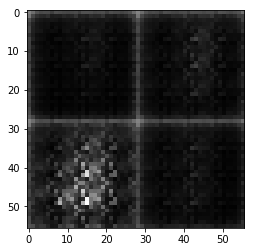

Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 1.2321
Epoch 1/2... Discriminator Loss: 0.2926... Generator Loss: 2.6198
Epoch 1/2... Discriminator Loss: 0.3122... Generator Loss: 2.3019
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 5.8367
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 5.1751
Epoch 1/2... Discriminator Loss: 0.3893... Generator Loss: 2.0067
Epoch 1/2... Discriminator Loss: 0.4335... Generator Loss: 2.0313
Epoch 1/2... Discriminator Loss: 0.3692... Generator Loss: 2.1377
Epoch 1/2... Discriminator Loss: 0.3299... Generator Loss: 2.7847
Epoch 1/2... Discriminator Loss: 0.3967... Generator Loss: 1.8885


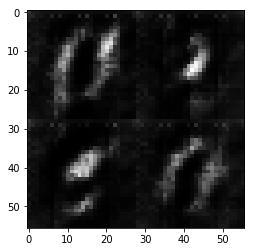

Epoch 1/2... Discriminator Loss: 0.4132... Generator Loss: 1.8925
Epoch 1/2... Discriminator Loss: 0.2650... Generator Loss: 2.0799
Epoch 1/2... Discriminator Loss: 0.3043... Generator Loss: 1.9674
Epoch 1/2... Discriminator Loss: 0.3943... Generator Loss: 3.9933
Epoch 1/2... Discriminator Loss: 0.1917... Generator Loss: 2.6992
Epoch 1/2... Discriminator Loss: 0.1692... Generator Loss: 2.6908
Epoch 1/2... Discriminator Loss: 0.1625... Generator Loss: 2.7121
Epoch 1/2... Discriminator Loss: 0.2237... Generator Loss: 2.0556
Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 3.8991
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.6479


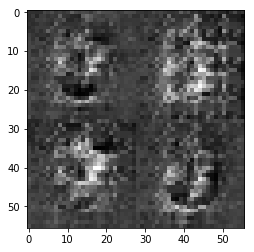

Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 1.0356
Epoch 1/2... Discriminator Loss: 0.9968... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 1.6169... Generator Loss: 0.3236
Epoch 1/2... Discriminator Loss: 0.5022... Generator Loss: 1.7608
Epoch 1/2... Discriminator Loss: 0.5758... Generator Loss: 1.1654
Epoch 1/2... Discriminator Loss: 0.4360... Generator Loss: 1.6585
Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 1.3449
Epoch 1/2... Discriminator Loss: 0.5933... Generator Loss: 1.2319
Epoch 1/2... Discriminator Loss: 0.4802... Generator Loss: 1.6565
Epoch 1/2... Discriminator Loss: 0.6373... Generator Loss: 1.2703


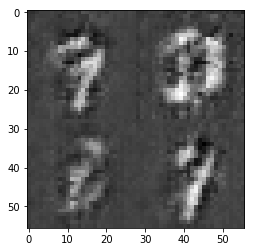

Epoch 1/2... Discriminator Loss: 0.6185... Generator Loss: 1.4507
Epoch 1/2... Discriminator Loss: 0.5514... Generator Loss: 2.1521
Epoch 1/2... Discriminator Loss: 0.4432... Generator Loss: 1.5692
Epoch 1/2... Discriminator Loss: 0.4195... Generator Loss: 1.6056
Epoch 1/2... Discriminator Loss: 0.4974... Generator Loss: 2.9808
Epoch 1/2... Discriminator Loss: 0.4426... Generator Loss: 1.5247
Epoch 2/2... Discriminator Loss: 0.4234... Generator Loss: 1.4149
Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 1.2177
Epoch 2/2... Discriminator Loss: 0.3602... Generator Loss: 2.0283
Epoch 2/2... Discriminator Loss: 0.3597... Generator Loss: 2.4145


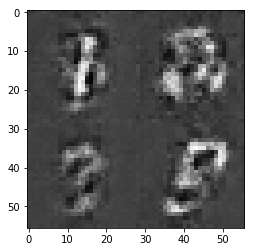

Epoch 2/2... Discriminator Loss: 0.3429... Generator Loss: 1.8020
Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 3.1129
Epoch 2/2... Discriminator Loss: 0.3223... Generator Loss: 1.9022
Epoch 2/2... Discriminator Loss: 0.3147... Generator Loss: 1.9205
Epoch 2/2... Discriminator Loss: 0.3943... Generator Loss: 2.9285
Epoch 2/2... Discriminator Loss: 0.2563... Generator Loss: 2.4259
Epoch 2/2... Discriminator Loss: 0.2962... Generator Loss: 2.0447
Epoch 2/2... Discriminator Loss: 0.3018... Generator Loss: 1.7589
Epoch 2/2... Discriminator Loss: 0.3729... Generator Loss: 1.4155
Epoch 2/2... Discriminator Loss: 0.2297... Generator Loss: 2.3394


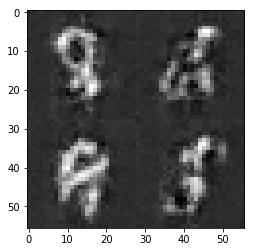

Epoch 2/2... Discriminator Loss: 0.2418... Generator Loss: 2.2825
Epoch 2/2... Discriminator Loss: 0.1873... Generator Loss: 2.9272
Epoch 2/2... Discriminator Loss: 0.2877... Generator Loss: 1.8050
Epoch 2/2... Discriminator Loss: 0.2559... Generator Loss: 1.8982
Epoch 2/2... Discriminator Loss: 0.3630... Generator Loss: 1.4052
Epoch 2/2... Discriminator Loss: 0.5777... Generator Loss: 0.9440
Epoch 2/2... Discriminator Loss: 1.1793... Generator Loss: 4.4729
Epoch 2/2... Discriminator Loss: 0.5451... Generator Loss: 1.8915
Epoch 2/2... Discriminator Loss: 0.2868... Generator Loss: 1.8737
Epoch 2/2... Discriminator Loss: 0.3278... Generator Loss: 1.7103


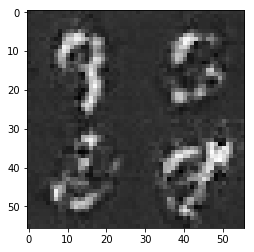

Epoch 2/2... Discriminator Loss: 0.2021... Generator Loss: 2.2501
Epoch 2/2... Discriminator Loss: 0.1613... Generator Loss: 2.7286
Epoch 2/2... Discriminator Loss: 0.2549... Generator Loss: 1.9394
Epoch 2/2... Discriminator Loss: 0.1858... Generator Loss: 2.4609
Epoch 2/2... Discriminator Loss: 0.1535... Generator Loss: 2.5806
Epoch 2/2... Discriminator Loss: 0.1782... Generator Loss: 2.5688
Epoch 2/2... Discriminator Loss: 0.1998... Generator Loss: 2.1059
Epoch 2/2... Discriminator Loss: 0.1968... Generator Loss: 2.1701
Epoch 2/2... Discriminator Loss: 0.3599... Generator Loss: 1.4046
Epoch 2/2... Discriminator Loss: 0.2049... Generator Loss: 2.1849


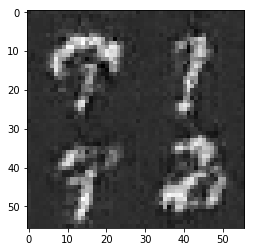

Epoch 2/2... Discriminator Loss: 0.2032... Generator Loss: 2.1935
Epoch 2/2... Discriminator Loss: 0.1302... Generator Loss: 2.5009
Epoch 2/2... Discriminator Loss: 0.1307... Generator Loss: 3.5414
Epoch 2/2... Discriminator Loss: 0.1404... Generator Loss: 2.6794
Epoch 2/2... Discriminator Loss: 0.1621... Generator Loss: 2.3773
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 4.5065
Epoch 2/2... Discriminator Loss: 0.6942... Generator Loss: 1.2624
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 0.2869... Generator Loss: 2.0928
Epoch 2/2... Discriminator Loss: 0.2504... Generator Loss: 2.0148


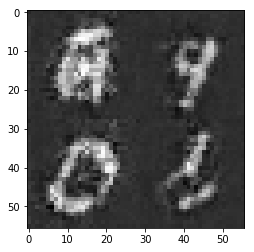

Epoch 2/2... Discriminator Loss: 0.1840... Generator Loss: 2.1797
Epoch 2/2... Discriminator Loss: 0.3159... Generator Loss: 1.6268
Epoch 2/2... Discriminator Loss: 0.1554... Generator Loss: 2.4646


In [28]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 1.6449
Epoch 1/1... Discriminator Loss: 0.2040... Generator Loss: 1.9685
Epoch 1/1... Discriminator Loss: 0.1576... Generator Loss: 2.4084
Epoch 1/1... Discriminator Loss: 0.2412... Generator Loss: 2.0093
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 1.7933
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 8.8628
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 2.0117


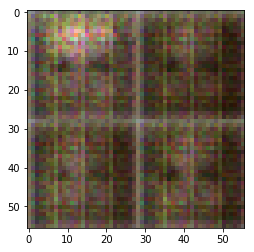

Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 1.6703
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 1.6018
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.3515
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.7670... Generator Loss: 0.3460
Epoch 1/1... Discriminator Loss: 1.7000... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 0.9872


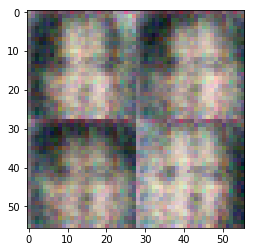

Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.7651


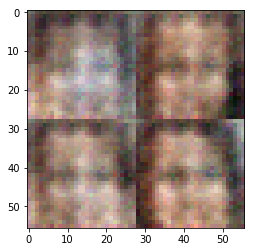

Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.3114
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.8942


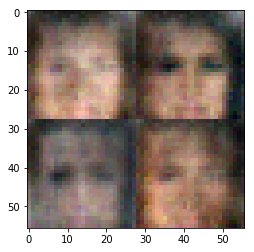

Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.8302
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.2364
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 1.3322


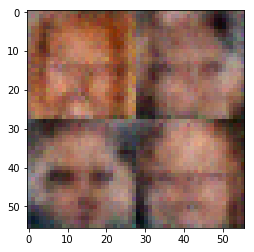

Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.8055


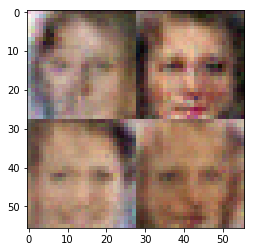

Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 1.1198


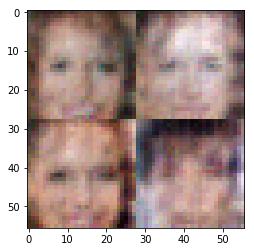

Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 1.2573
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 1.4328
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.0068


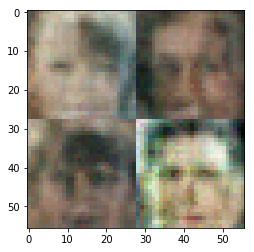

Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.1969
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.8787


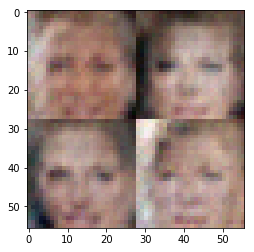

Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.1160
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.5155


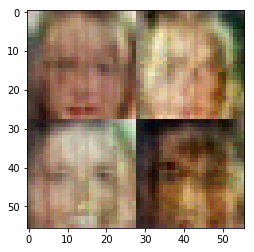

Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.8479


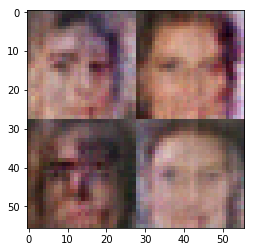

Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.8734


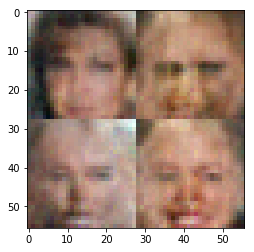

Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 1.7726
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.7395


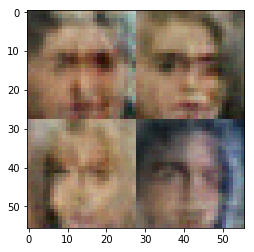

Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.6776
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 2.4104
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.6851


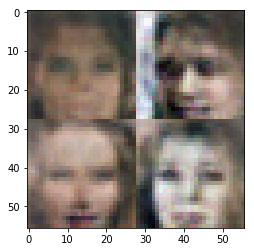

Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 1.7498... Generator Loss: 0.2792
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.8376
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.0242


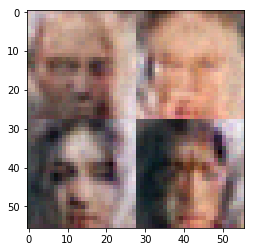

Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 1.0345


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.